This notebook is for analyzing absorption features in the KELT-9b_20180703_PEPSI dataset via cross correlation.

# Imports

In [556]:
import glob
import os
os.chdir('/home/paiasnodkar.1/AtmosphericDynamics/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

import scipy.signal

import astropy.units as u

import pandas as pd

try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

import importlib
    
import TransmissionSpectroscopy_lib as TSL

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

# Read in data

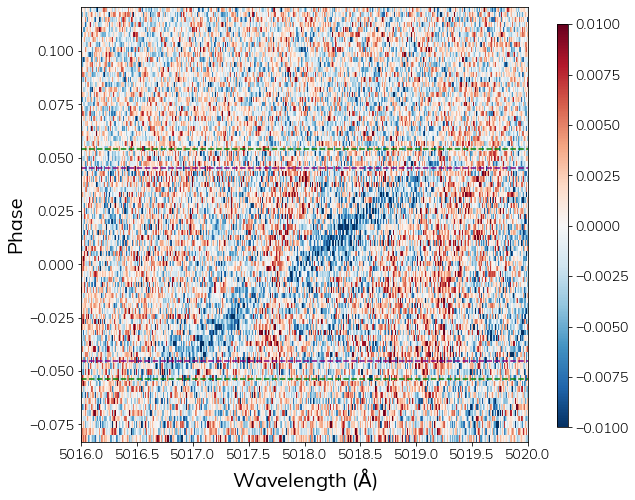

In [155]:
# Data set labels
planet_name = 'KELT-9b_20180703_PEPSI'
planet_name_ref = 'KELT-9b'
planet_config = 'planet_configs/'+planet_name_ref+'_config.txt'
petit_config = 'petitRADTRANS_configs/'+planet_name_ref+'_petitRADTRANS_config.txt'


# Read in data and crop
with open('data/'+planet_name_ref+'/'+planet_name+'/'+planet_name+'_transmission.pkl', "rb") as input_file: # stellar or transmission
    FM = pickle.load(input_file)

# Plot
vrange = [-0.01, 0.01]
vel_range = [5016, 5020]

fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(FM.wav.value, FM.phaseFold().value, FM.fluxes, vmin=vrange[0], vmax=vrange[1], 
                   cmap='RdBu_r')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.xlim(vel_range[0], vel_range[1])
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel(r'Phase')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.png', dpi=300, bbox_inches='tight')
# plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.pdf')
plt.show()

# Make species template

Run petitRADTRANS model


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



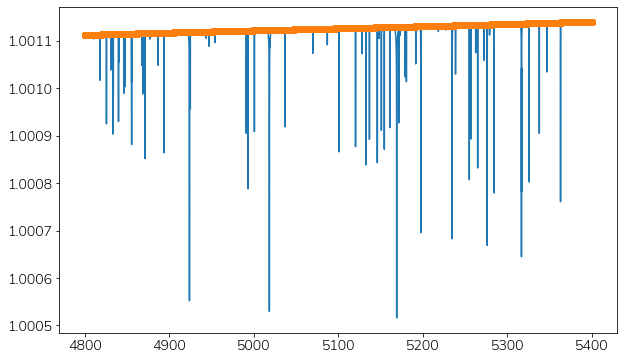

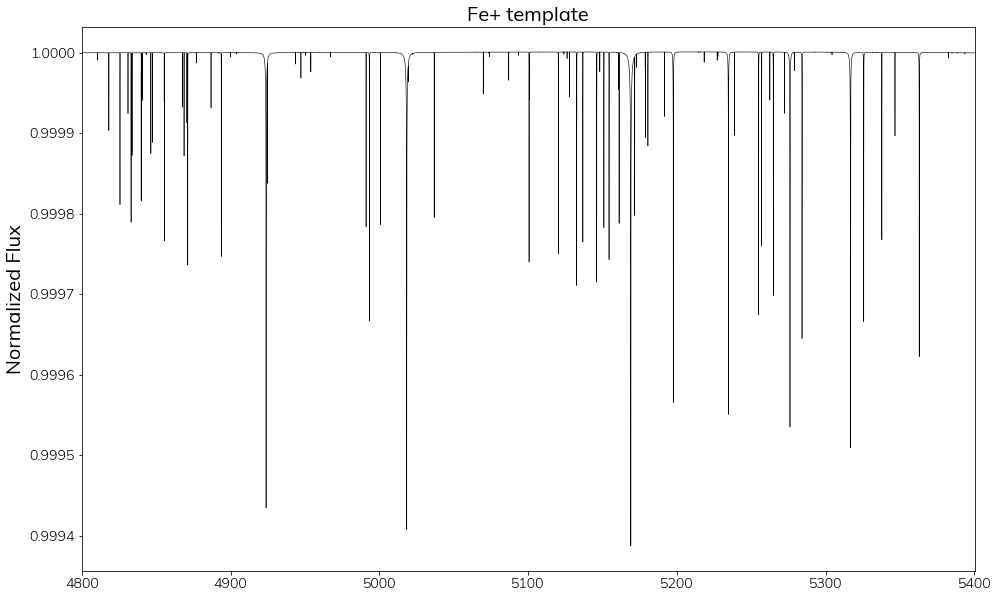

In [195]:
species = ['Fe+']
lambda_low = 4800
lambda_up = 5400
pressures = np.logspace(-10, 2, 130)
contribution = True
Pcloud = False
in_air = True
normalize = True
cutoff = 0.99
exclude = None
smooth = 1e-2

if contribution:    
    wav_model, rad_model, flx_model, temperatures, contr_func = TSL.make_transmission_template(planet_name,
                            planet_config, petit_config, species, lambda_low, lambda_up, pressures, 
                            contribution=contribution, Pcloud=Pcloud, in_air=in_air, normalize=normalize, 
                            cutoff=cutoff, exclude=exclude, smooth=smooth)
else:
    wav_model, rad_model, flx_model, temperatures = TSL.make_transmission_template(planet_name,
                            planet_config, petit_config, species, lambda_low, lambda_up, pressures, 
                            contribution=contribution, Pcloud=Pcloud, in_air=in_air, normalize=normalize, 
                            cutoff=cutoff, exclude=exclude, smooth=smooth)
    
# Plot template
plt.figure(figsize=(16,10))
plt.plot(wav_model, flx_model, 'k', linewidth=0.6)
plt.xlim(min(wav_model), max(wav_model))
plt.ylabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.title(species_str+' template')
plt.show()

Read in existing petitRADTRANS template and contribution function

In [196]:
template_dir = 'planet_templates/'+planet_name+'/'
species_str = species[0]
lambda_str = str(lambda_low)+'_'+str(lambda_up)
template_filename = template_dir+planet_name+'_'+species_str+'_'+lambda_str+'_template.csv'
PT_filename = template_dir+planet_name+'_'+species_str+'_'+lambda_str+'_PT.csv'
contr_func_filename = template_dir+planet_name+'_'+species_str+'_'+lambda_str+'_contributionFunction.npy'

# Read in template
df = pd.read_csv(template_filename, comment='#')
wav_model, rad_model, flx_model = np.array(df['Wavelength']), np.array(df['Radius']), np.array(df['Flux'])

# Read in P-T profile
df = pd.read_csv(PT_filename, comment='#')
pressures, temperatures = np.array(df['Pressure']), np.array(df['Temperature'])

# Read in contribution function
contr_func = np.load(contr_func_filename)

Plot contribution function and effective pressure probed at each wavelength; identify low and high altitude features.

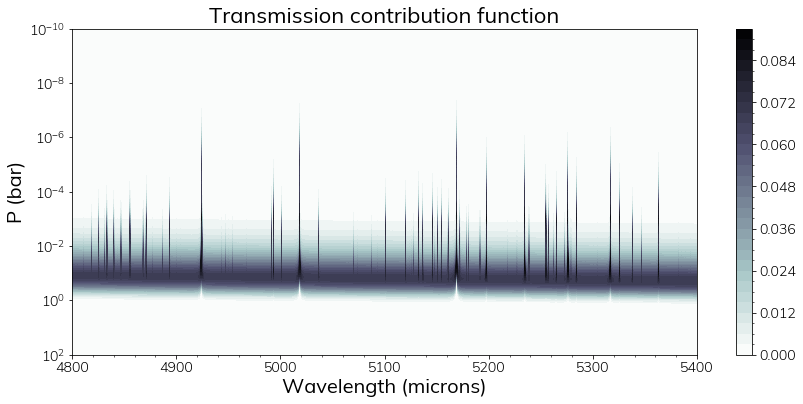

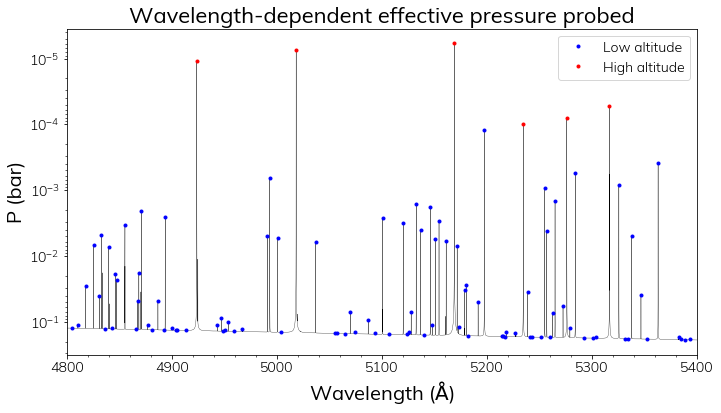

In [582]:
# Contribution function
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.contourf(wav_model, pressures, contr_func, 30,cmap=plt.cm.bone_r)
plt.xlim(min(wav_model), max(wav_model))
plt.yscale('log')
ax.invert_yaxis()
plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Transmission contribution function')
plt.colorbar()
plt.show()

# Effective pressure
pressures_eff = np.dot(pressures, contr_func)

# Identify lines
pressure_threshhold = 5
line_indices, = scipy.signal.argrelextrema(pressures_eff, np.less, order=200)
high_alt = pressures_eff[line_indices] <= np.percentile(pressures_eff[line_indices], pressure_threshhold)
low_alt = pressures_eff[line_indices] > np.percentile(pressures_eff[line_indices], pressure_threshhold)

fig, ax = plt.subplots(1, 1, figsize=(11.3, 6))
plt.plot(wav_model, pressures_eff, 'k', linewidth=0.3)
plt.plot(wav_model[line_indices][low_alt], pressures_eff[line_indices][low_alt], 'b.', label='Low altitude')
plt.plot(wav_model[line_indices][high_alt], pressures_eff[line_indices][high_alt], 'r.', label='High altitude')
plt.xlim(min(wav_model), max(wav_model))
plt.yscale('log')
ax.invert_yaxis()
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('P (bar)')
plt.title('Wavelength-dependent effective pressure probed')
plt.legend(fontsize=14)
plt.show()

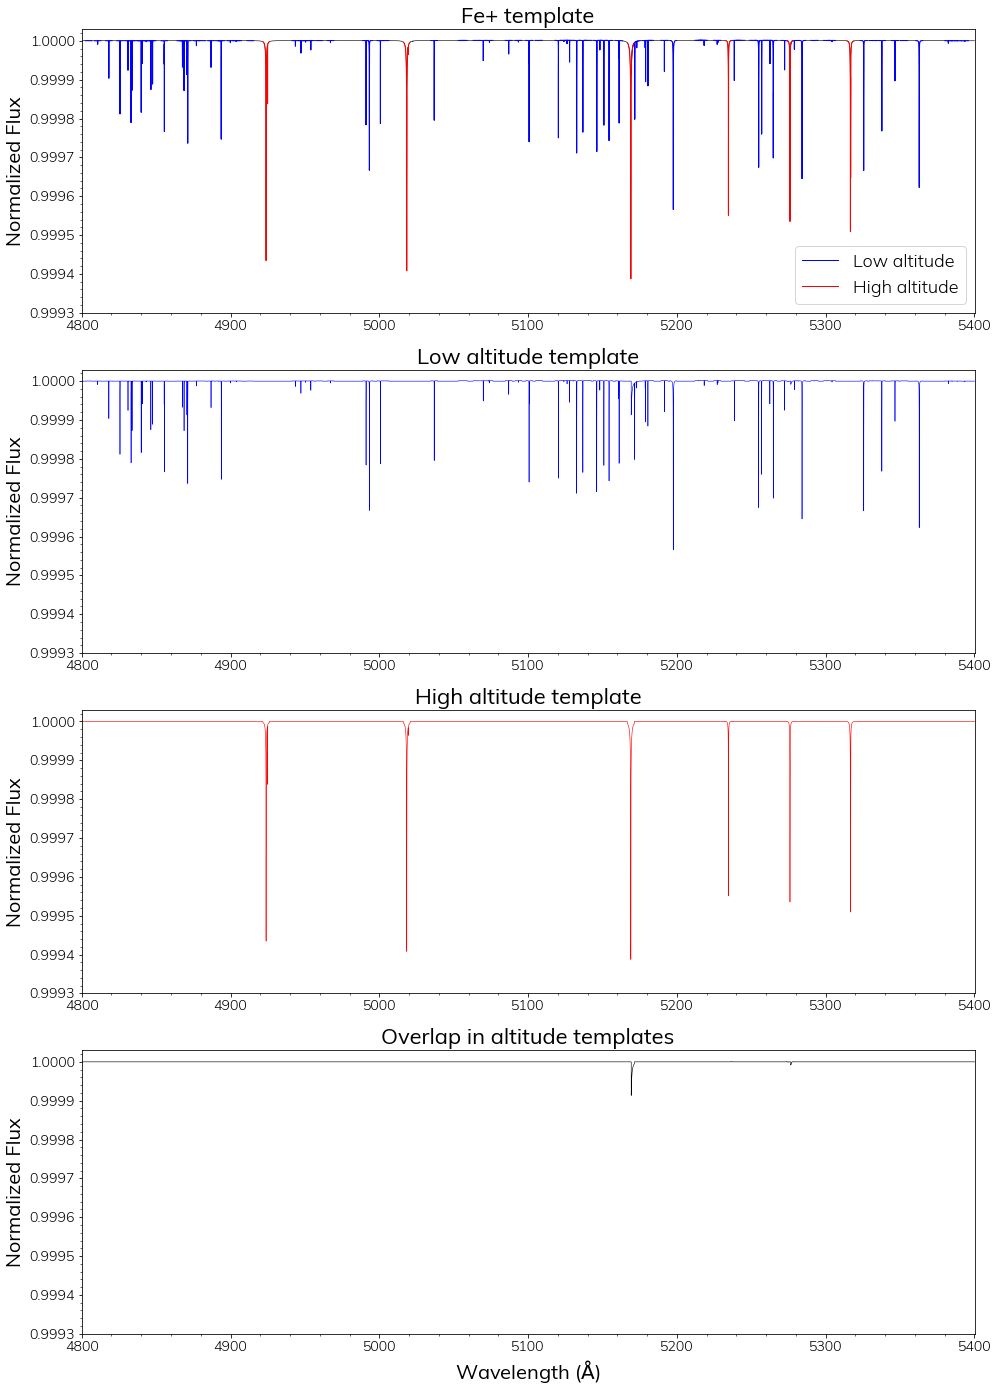

In [583]:
def make_altitude_mask(alt_indices, width, num_wav):
    ''' Builds a mask for specifying lines of a given alitude assuming a fixed line width.
    
        Parameters
        ----------
        alt_indices : 1D numpy array
            Array of indices corresponding to spectral line centers for a given altitude bin
        width : integer
            Assumed width of lines
        num_wav : integer
            Number of elements in wavelength array
            
        Returns
        -------
        ind_lines : 1D numpy array
            Array of indices corresponding to spectral lines for a given altitude bin       
    '''
    ind_lines = np.array([], dtype=int)
    ind_lines_list = []
    for ind in alt_indices:
        ind_low = ind - high_width
        ind_up = ind + high_width + 1
        if ind_low < 0:
            ind_low = 0
        if ind_up > len(wav_model) - 1:
            ind_up = len(wav_model) - 1
        ind_lines = np.hstack([ind_lines, np.arange(ind_low, ind_up, dtype=int)])
        ind_lines_list.append(np.arange(ind_low, ind_up, dtype=int))
    return ind_lines, ind_lines_list       

# Make low altitude template
low_width = 10
low_lines, low_lines_list = make_altitude_mask(line_indices[low_alt], low_width, len(wav_model))
flx_model_low = np.ones_like(flx_model)
flx_model_low[low_lines] = flx_model[low_lines]

# Make high altitude template
high_width = 450
high_lines, high_lines_list = make_altitude_mask(line_indices[high_alt], high_width, len(wav_model))
flx_model_high = np.ones_like(flx_model)
flx_model_high[high_lines] = flx_model[high_lines]

# Make overlap template
overlap_lines = np.intersect1d(low_lines, high_lines)
flx_model_overlap = np.ones_like(flx_model)
flx_model_overlap[overlap_lines] = flx_model[overlap_lines]

ymin, ymax = 0.9993, 1.00003

fig, ax = plt.subplots(4, 1, figsize=(16,24))

# Plot template and identify lines of different altitudes
ax[0].plot(wav_model, flx_model, 'k', linewidth=0.6)
# Plot low altitude lines
linewidth = 1
for low_line in low_lines_list[:-1]:
    ax[0].plot(wav_model[low_line], flx_model[low_line], 'b-', linewidth=linewidth)
ax[0].plot(wav_model[low_lines_list[-1]], flx_model[low_lines_list[-1]], 'b-', linewidth=linewidth, label='Low altitude')
# Plot high altitude lines
for high_line in high_lines_list[:-1]:
    ax[0].plot(wav_model[high_line], flx_model[high_line], 'r-', linewidth=linewidth)
ax[0].plot(wav_model[high_lines_list[-1]], flx_model[high_lines_list[-1]], 'r-', linewidth=linewidth, label='High altitude')
ax[0].set_xlim(min(wav_model), max(wav_model))
ax[0].set_ylim(ymin, ymax)
ax[0].legend(fontsize=18, loc='lower right')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title(species_str+' template')

# Plot low altitude template
ax[1].plot(wav_model, flx_model_low, 'b-', linewidth=0.6)
ax[1].set_xlim(min(wav_model), max(wav_model))
ax[1].set_ylim(ymin, ymax)
ax[1].set_title('Low altitude template')
ax[1].set_ylabel('Normalized Flux')

# Plot low altitude template
ax[2].plot(wav_model, flx_model_high, 'r-', linewidth=0.6)
ax[2].set_xlim(min(wav_model), max(wav_model))
ax[2].set_ylim(ymin, ymax)
ax[2].set_ylabel('Normalized Flux')
ax[2].set_title('High altitude template')

# Plot overlap in templates
ax[3].plot(wav_model, flx_model_overlap, 'k', linewidth=0.6)
ax[3].set_xlim(min(wav_model), max(wav_model))
ax[3].set_ylim(ymin, ymax)
ax[3].set_title('Overlap in altitude templates')
ax[3].set_ylabel('Normalized Flux')
ax[3].set_xlabel(r'Wavelength ($\mathrm{\AA}$)')

plt.savefig('figs/templates/'+planet_name_ref+'_'+species_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-correlate

Full template

In [584]:
def SME_interp_planet_rad_CCF(f, is_in, vels, phases, planet_name, species):
    ''' Returns SME synthetic spectra interpolated across planet radius values and wavelengths.
        Inputs:
        - Relative planet radius fraction
        - List of booleans indicating observations that are fully in-transit
        - List of wavelength range of interest
        Outputs
        -Array of 2D flux map corresponding to defined planet radius and wavelength range
    '''
    if f < 0.7:
        f = 0.71
    if f > 2.5:
        f = 2.49
    r_low = str(f)[:3]
    r_low_float = float(r_low)
    r_low = r_low[0]+'_'+r_low[2]
    r_up = str(float(str(f)[:3]) + 0.1)
    r_up_float = float(r_up)
    r_up = r_up[0]+'_'+r_up[2]
    vels_low = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_vels_'+species+'_'+r_low+'.npy')
    phases_low = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_phases_'+r_low+'.npy')
    CCF_low = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_CCF_'+species+'_'+r_low+'.npy')
    interp_phase = scipy.interpolate.RectBivariateSpline(phases_low, vels_low, CCF_low)
    CCF_low = interp_phase(phases, vels)
    vels_up = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_vels_'+species+'_'+r_up+'.npy')
    phases_up = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_phases_'+r_up+'.npy')
    CCF_up = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/SME_models/'+planet_name+'/'+planet_name+'_CCF_'+species+'_'+r_up+'.npy')
    interp_phase = scipy.interpolate.RectBivariateSpline(phases_up, vels_up, CCF_up)
    CCF_up = interp_phase(phases, vels)
    CCF_r = np.empty([len(CCF_low), len(vels)])
    for i in range(len(CCF_low)):
        interp_r = scipy.interpolate.interp2d(vels, [r_low_float, r_up_float], [CCF_low[i], CCF_up[i]], kind='linear')
        CCF_r[i] = interp_r(vels, f)
    return CCF_r.reshape(len(phases),len(vels))

def SME_add_planet_CCF_v2(theta, vels, is_in, phases, planet_name, species):
    ''' Adds Gaussian planet absorption to radius-interpolated SME models.
        Inputs:
        - List of parameters:
            - Relative planet radius fraction
            - RV semi-amplitude
            - Planet atmosphere wind speed
            - Planet absorption depth
            - Planet absorption width
        - List of wavelengths
        - List of velocities corresponding to wavelengths
        - List of booleans indicating observations that are fully in-transit
        - List of times
        - Mid-transit time value
        - Orbital period value
        Outputs:
        - Array of 2D flux map that includes planet absorption signal
    '''
    f, Kp, v_wind, h, sig = theta
    CCFs_SME = SME_interp_planet_rad_CCF(f, is_in, vels, phases, planet_name, species) + 1.
    v_0 = TSL.RV_circular_orbit(phases*u.rad, Kp, v_wind).value
    for i, v in enumerate(v_0):
        if is_in[i]:
            T = 1. + h*np.exp(-((vels-v)**2)/(2*sig))
            CCFs_SME[i] = CCFs_SME[i]*T # Scale model by f, multiply absorption spectrum
    return CCFs_SME

Full template

Wind speed:  -8.182497268194998  km/s


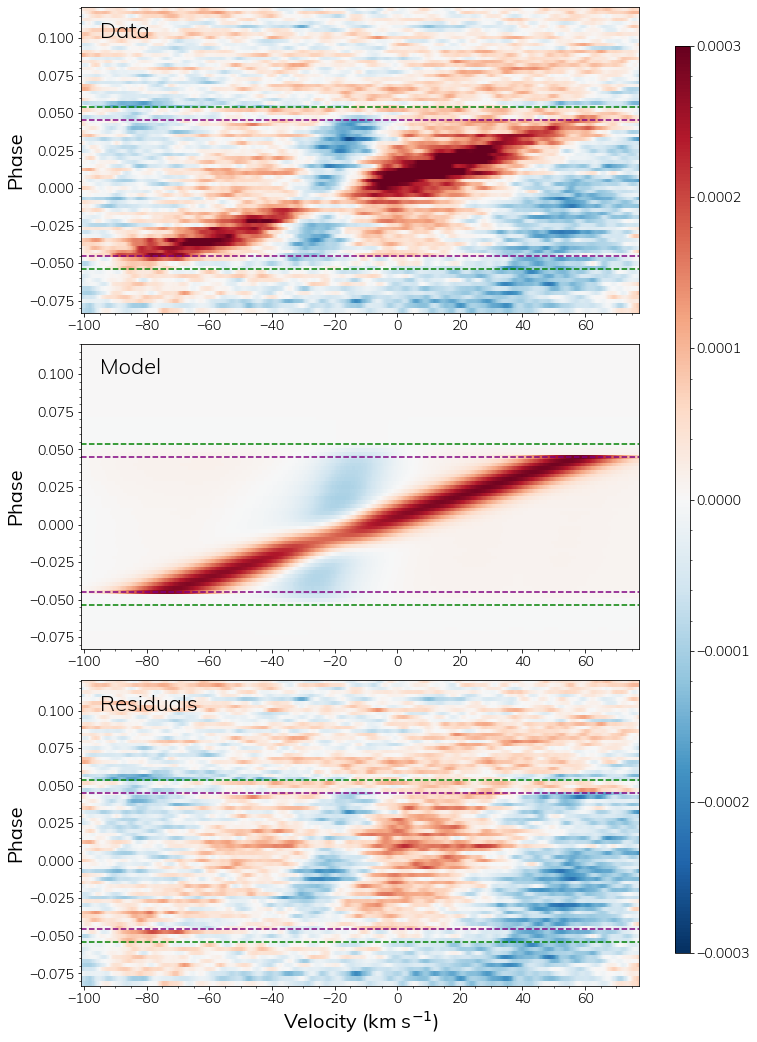

In [585]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)

# Shift for systemic velocity
v_sys_PEPSI = -17.86 * u.km/u.s
vels_corr = vels - v_sys_PEPSI

# Fit for wind speed

CCFs_model = lambda theta: SME_add_planet_CCF_v2(theta, vels_corr.value, FM.isIn(), FM.phaseFold(), 
                                                  planet_name, species)-1.
CCFs_shadow = lambda f: SME_interp_planet_rad_CCF(f, FM.isIn(), vels_corr.value, FM.phaseFold(), 
                                                      planet_name, species)
CCFs_model_min = lambda theta: np.sum((CCFs_model(theta) - CCFs)**2/CCFs_err**2)

guess = [1.1, 234, -10, 3e-4, 100]
bounds = [[0.8, 2.3], [200, 300], [-20, 0], [0, 1], [0, 500]]
res = scipy.optimize.minimize(CCFs_model_min, guess, bounds=bounds, tol=1e-12)
args = res.x

print('Wind speed: ', args[2], ' km/s')

vrange = [-3e-4, 3e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs - CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

High altitude

Wind speed:  -8.264673329880036  km/s


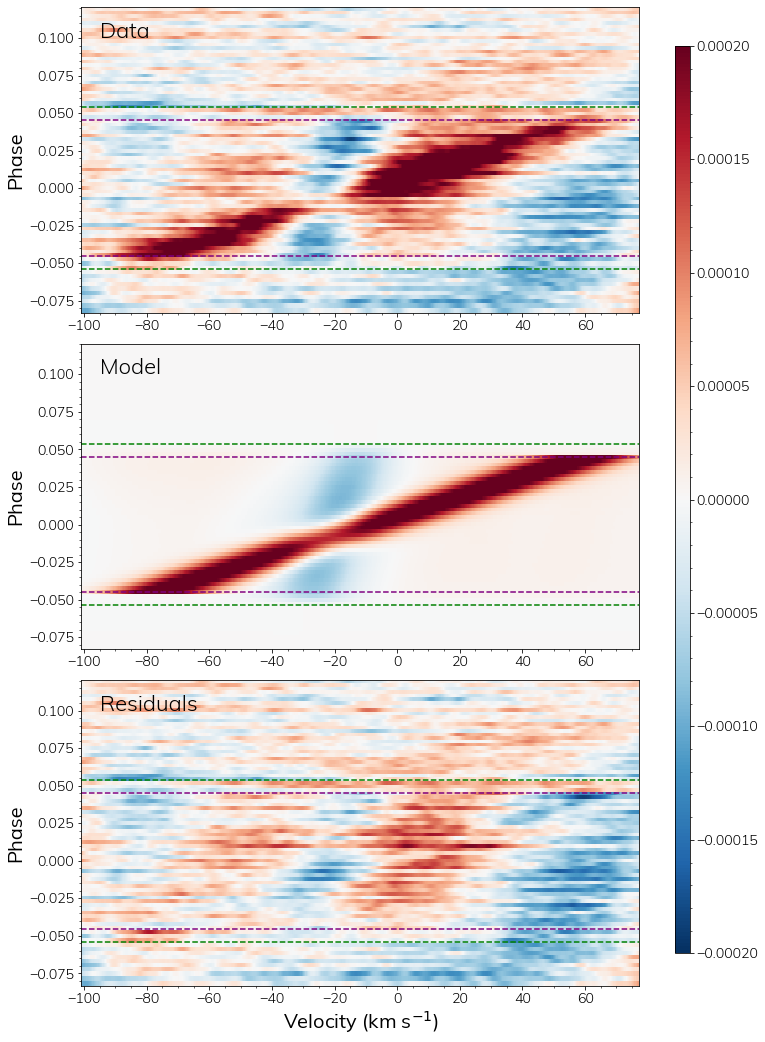

In [586]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model_high, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)

# Shift for systemic velocity
v_sys_PEPSI = -17.86 * u.km/u.s
vels_corr = vels - v_sys_PEPSI

# Fit for wind speed

CCFs_model = lambda theta: SME_add_planet_CCF_v2(theta, vels_corr.value, FM.isIn(), FM.phaseFold(), 
                                                  planet_name, species)-1.
CCFs_shadow = lambda f: SME_interp_planet_rad_CCF(f, FM.isIn(), vels_corr.value, FM.phaseFold(), 
                                                      planet_name, species)
CCFs_model_min = lambda theta: np.sum((CCFs_model(theta) - CCFs)**2/CCFs_err**2)

guess = [1.1, 234, -10, 3e-4, 100]
bounds = [[0.8, 2.3], [200, 300], [-20, 0], [0, 1], [0, 500]]
res = scipy.optimize.minimize(CCFs_model_min, guess, bounds=bounds, tol=1e-12)
args = res.x

print('Wind speed: ', args[2], ' km/s')

vrange = [-2e-4, 2e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs - CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Low altitude

Wind speed:  -12.293160432100988  km/s


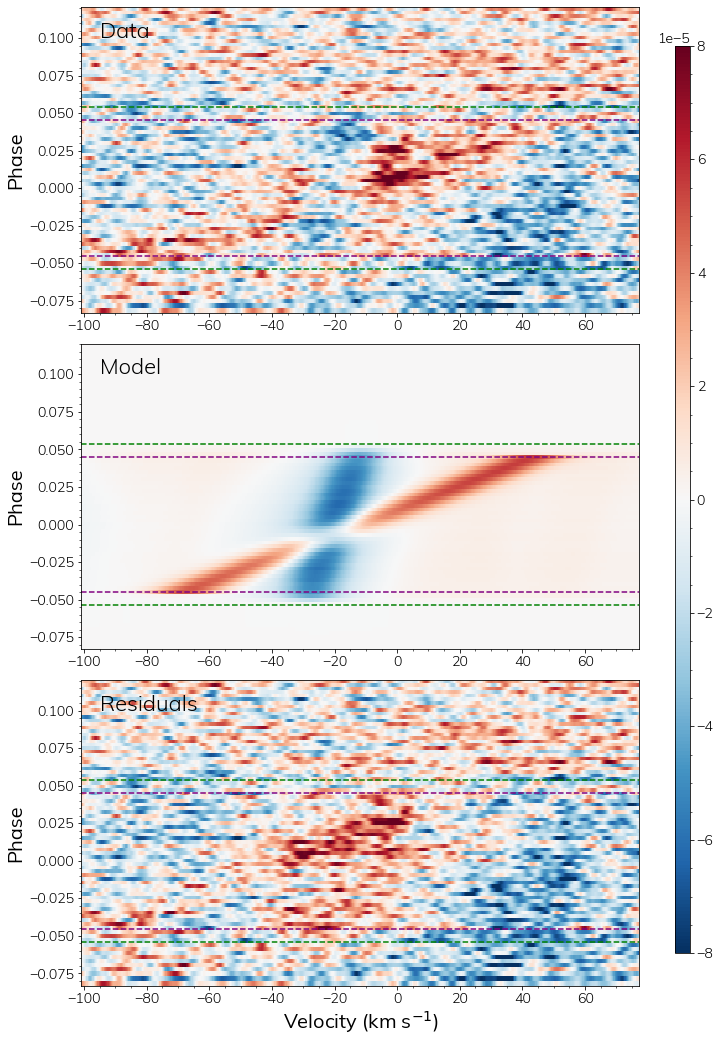

In [589]:
index_shift_low, index_shift_up = 300,150
flx_model_interp = TSL.interpolate_xy(wav_model, flx_model_low, FM.wav)
vels, CCFs, CCFs_err = TSL.FluxMap.cross_corr(FM.wav, FM.fluxes, FM.fluxes_err, flx_model_interp-1, 
                                      index_shift_low, index_shift_up)

# Shift for systemic velocity
v_sys_PEPSI = -17.86 * u.km/u.s
vels_corr = vels - v_sys_PEPSI

# Fit for wind speed

CCFs_model = lambda theta: SME_add_planet_CCF_v2(theta, vels_corr.value, FM.isIn(), FM.phaseFold(), 
                                                  planet_name, species)-1.
CCFs_shadow = lambda f: SME_interp_planet_rad_CCF(f, FM.isIn(), vels_corr.value, FM.phaseFold(), 
                                                      planet_name, species)
CCFs_model_min = lambda theta: np.sum((CCFs_model(theta) - CCFs)**2/CCFs_err**2)

guess = [1.1, 234, -10, 1e-4, 100]
bounds = [[0.8, 2.3], [200, 300], [-20, 0], [0, 1], [0, 500]]
res = scipy.optimize.minimize(CCFs_model_min, guess, bounds=bounds, tol=1e-12)
args = res.x

print('Wind speed: ', args[2], ' km/s')

vrange = [-0.8e-4, 0.8e-4]
fig, ax = plt.subplots(3, 1, figsize=(10,18))
plt.subplots_adjust(hspace=0.1)
# Data
im = ax[0].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[0].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[0].set_ylabel(r'Phase')
ax[0].text(-95, 0.1, r'Data', fontsize=22)

# Model
im = ax[1].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[1].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[1].set_ylabel(r'Phase')
ax[1].text(-95, 0.1, r'Model', fontsize=22)

# Residuals
im = ax[2].pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs - CCFs_model(args), cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
ax[2].axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
ax[2].set_xlabel(r'Velocity (km s$^{-1}$)')
ax[2].set_ylabel(r'Phase')
ax[2].text(-95, 0.1, r'Residuals', fontsize=22)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Beginning SYSREM...
Systematic removed: 0
Mean error: 1.756697833201027e-05


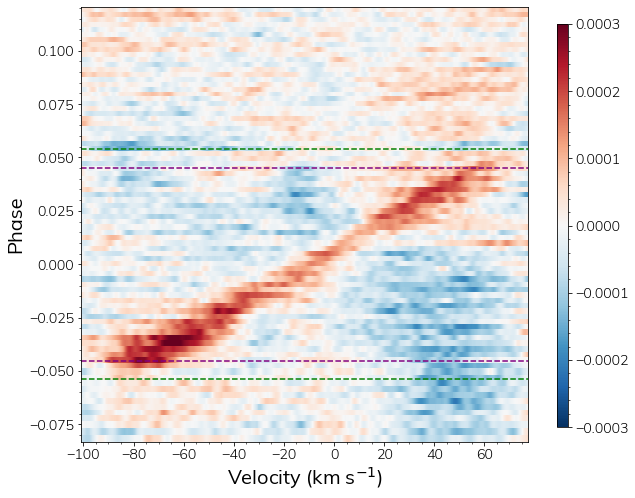

In [502]:
def SYSREM(wav, flxs, flxs_err, num_iter=10, num_sys=5):
    ''' Performs SYSREM algorithm for removing linearly related systematics from spectra. Adapted from PySysRem by     Dr. Stephanie T. Douglas (https://github.com/stephtdouglas) and Dr. Marshall Johnson's code (https://github.com/c    aptain-exoplanet).
        Inputs:
        - wav: 1-D numpy array of wavelengths
        - flxs: 2-D numpy array of spectral fluxes, continuum-normalized with baseline at 1
        - flxs_err: 2-D numpy array of spectral flux errors
        - num_iter: integer representing number of iterations over which to minimize a and c for a given systemati    c
        - num_sys: integer representing number of systematics over which to perform systematic correction
        Outputs:
        - flxs_SYSREM = 2-D numpy array of spectral fluxes corrected for systematics
    '''
    c = np.zeros(np.shape(flxs)[1]) # defined for each wavelength
    a = np.ones(np.shape(flxs)[0]) # defined for each observation
    flxs_SYSREM = np.copy(flxs) # set baseline around 0
    flxs_err_sq = flxs_err ** 2.

    print('Beginning SYSREM...')
    for sys in range(num_sys): # iterate of number of systematics
        for iter in range(num_iter): # iterate of number of minimization iterations
            # Compute c (~extinction coefficient for each wavelength)
            c_num = np.sum(a*flxs_SYSREM.T/flxs_err_sq.T, axis=1)
            c_denom = np.sum(a**2/flxs_err_sq.T, axis=1)
            c = c_num/c_denom
            # Compute a (~airmass across observations)
            a_num = np.sum(c*flxs_SYSREM/flxs_err_sq, axis=1)
            a_denom = np.sum(c**2/flxs_err_sq, axis=1)
            a = a_num/a_denom

        # Compute systemic errors
        syserr = np.ones_like(flxs)
        syserr *= c
        syserr = (syserr.T * a).T
        flxs_SYSREM -= syserr
        print('Systematic removed:', sys)
        print('Mean error:', np.mean(syserr))
    #flxs_SYSREM += med # Return baseline back to 1
    return flxs_SYSREM, syserr

CCFs_corr_SYSREM, CCFs_corr_SYSREM_err = SYSREM(vels_corr.value, CCFs_corr, CCFs_err, num_iter=100, num_sys=1)

vrange = [-3e-4, 3e-4]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels_corr.value, FM.phaseFold().value, CCFs_corr_SYSREM, cmap='RdBu_r', vmin=vrange[0], vmax=vrange[1])
plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.xlabel(r'Velocity (km s$^{-1}$)')
plt.ylabel(r'Phase')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.png', dpi=300, bbox_inches='tight')
plt.show()

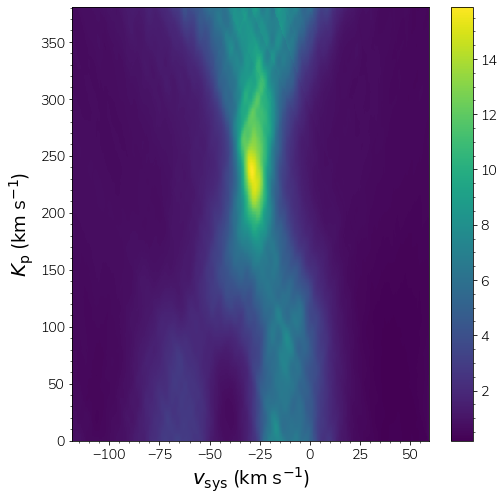

In [524]:
from astropy.modeling import models, fitting

v_rot = (2 * np.pi * FM.R_p[0])/FM.P[0]
v_rot = v_rot.to(u.km/u.s)
num_vels, num_K_pl = len(vels), 300
a_p = 0.03462 * u.AU
K_star = TSL.RV_semiAmplitude(FM.M_star[0], FM.M_p[0], a_p, 0, FM.i_p[0])
K_pl = K_star * FM.M_star[0].to(u.kg)/FM.M_p[0].to(u.kg)
K_pl_arr = np.linspace(0*(u.km/u.s), 1.5*K_pl.to(u.km/u.s), num_K_pl)

SNRs = np.ones((num_K_pl, num_vels)) * np.nan
for row, K_pl_test in enumerate(K_pl_arr):
    planet_vels = TSL.RV_circular_orbit(FM.phaseFold()[FM.isIn()].value, K_pl_test, 0).to(u.km/u.s)
    CCFs_shifted = np.array([TSL.interpolate_xy(vels-planet_vels[i], CCFs_corr[FM.isIn()][i], vels, 
                                                  fill_value=0) for i in range(len(CCFs_corr[FM.isIn()]))])
    CCF_stacked = np.sum(CCFs_shifted, axis=0)
    noise_arr = CCF_stacked[abs(vels)>1.5*v_rot]
    noise = np.std(noise_arr)
    SNRs[row,:] = CCF_stacked/noise 

SNRs -= np.median(SNRs)
where_plot = abs(vels) < 150 * u.km/u.s

# vrange = [0, 3]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels[where_plot].value, abs(K_pl_arr.value), np.exp(SNRs[:,where_plot]))#, 
#                    vmin=vrange[0], vmax=vrange[1])
# im = ax.pcolormesh(vels[where_plot].value, abs(K_pl_arr.value), SNRs[:,where_plot])#, 
#                    vmin=vrange[0], vmax=vrange[1])
plt.xlabel(r'$v_{\mathrm{sys}}$ (km s$^{-1}$)')
plt.ylabel('$K_{\mathrm{p}}$ (km s$^{-1}$)')
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im)#, cax=cbar_ax)
plt.show() 

In [526]:
args

array([ 1.10025682e+00,  2.36165558e+02, -8.18249727e+00,  2.74532054e-04,
        1.21901108e+02])

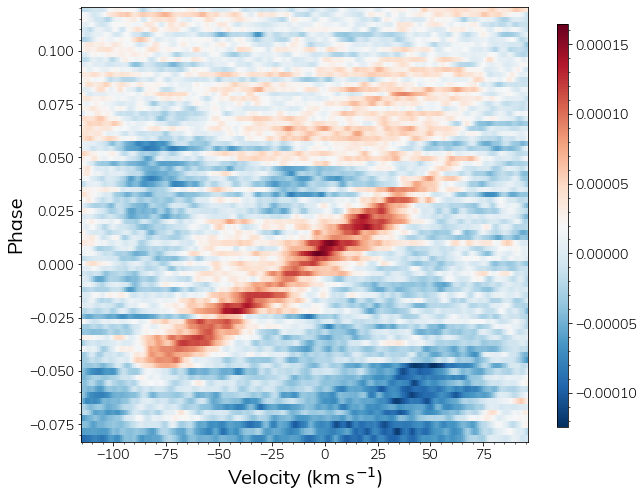

In [511]:
chain_flat = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_chain_CCF_GP_Fe+.npy')
theta_best = np.percentile(chain_flat, 50, axis=0)
phases = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_phases_CCF_Fe+.npy')
vels = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_vels_CCF_Fe+.npy')
CCFs = np.load('/home/paiasnodkar.1/AtmosphericRetrieval/MCMC/KELT-9b/KELT-9b_data_CCF_Fe+.npy')
CCFs_shadow = SME_interp_planet_rad_CCF(theta_best[0], FM.isIn(), vels, FM.phaseFold(), 'KELT-9b', 
                                         species_str)
CCFs_corr = CCFs-1-CCFs_shadow

# Plot
vrange = [-3e-4, 3e-4]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels, phases, CCFs-1-CCFs_shadow, cmap='RdBu_r')#, vmin=vrange[0], vmax=vrange[1])
# plt.axhline(-FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
# plt.axhline(-FM.T_14[0]/(2*FM.P[0]) + FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
# plt.axhline(FM.T_14[0]/(2*FM.P[0]) - FM.tau[0]/FM.P[0], color='purple', linestyle='dashed')
# plt.axhline(FM.T_14[0]/(2*FM.P[0]), color='green', linestyle='dashed')
plt.xlabel(r'Velocity (km s$^{-1}$)')
plt.ylabel(r'Phase')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.savefig('figs/FluxMaps/'+planet_name+'_FeII_5016.png', dpi=300, bbox_inches='tight')
plt.show()

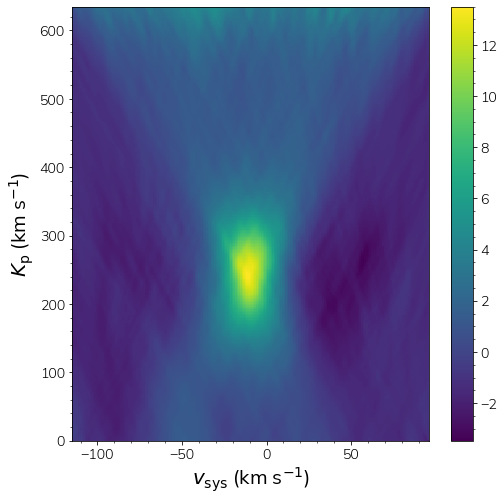

In [512]:
from astropy.modeling import models, fitting

v_rot = (2 * np.pi * FM.R_p[0])/FM.P[0]
v_rot = v_rot.to(u.km/u.s)
num_vels, num_K_pl = len(vels), 300
a_p = 0.03462 * u.AU
K_star = TSL.RV_semiAmplitude(FM.M_star[0], FM.M_p[0], a_p, 0, FM.i_p[0])
K_pl = K_star * FM.M_star[0].to(u.kg)/FM.M_p[0].to(u.kg)
K_pl_arr = np.linspace(0*(u.km/u.s), 2.5*K_pl.to(u.km/u.s), num_K_pl)

SNRs = np.ones((num_K_pl, num_vels)) * np.nan
for row, K_pl_test in enumerate(K_pl_arr):
    planet_vels = TSL.RV_circular_orbit(FM.phaseFold()[FM.isIn()].value, K_pl_test, 0).to(u.km/u.s)
    CCFs_shifted = np.array([TSL.interpolate_xy(vels-planet_vels[i].value, CCFs_corr[FM.isIn()][i], vels, 
                                                  fill_value=0) for i in range(len(CCFs[FM.isIn()]))])
    CCF_stacked = np.sum(CCFs_shifted, axis=0)
    noise_arr = CCF_stacked[abs(vels)>5*v_rot.value]
    noise = np.std(noise_arr)
    SNRs[row,:] = CCF_stacked/noise 

SNRs -= np.median(SNRs)
where_plot = abs(vels) < 150# * u.km/u.s

vrange = [-3, 5]
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.pcolormesh(vels[where_plot], abs(K_pl_arr.value), SNRs[:,where_plot])#, 
#                    vmin=vrange[0], vmax=vrange[1])
plt.xlabel(r'$v_{\mathrm{sys}}$ (km s$^{-1}$)')
plt.ylabel('$K_{\mathrm{p}}$ (km s$^{-1}$)')
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im)#, cax=cbar_ax)
plt.show() 

-11.466528220013963